In [1]:
### IMPORTS ###

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
class PimaDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.features = self.data.iloc[:, :-1].values
        self.output = self.data.iloc[:, -1].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.features[idx], self.output[idx]
    

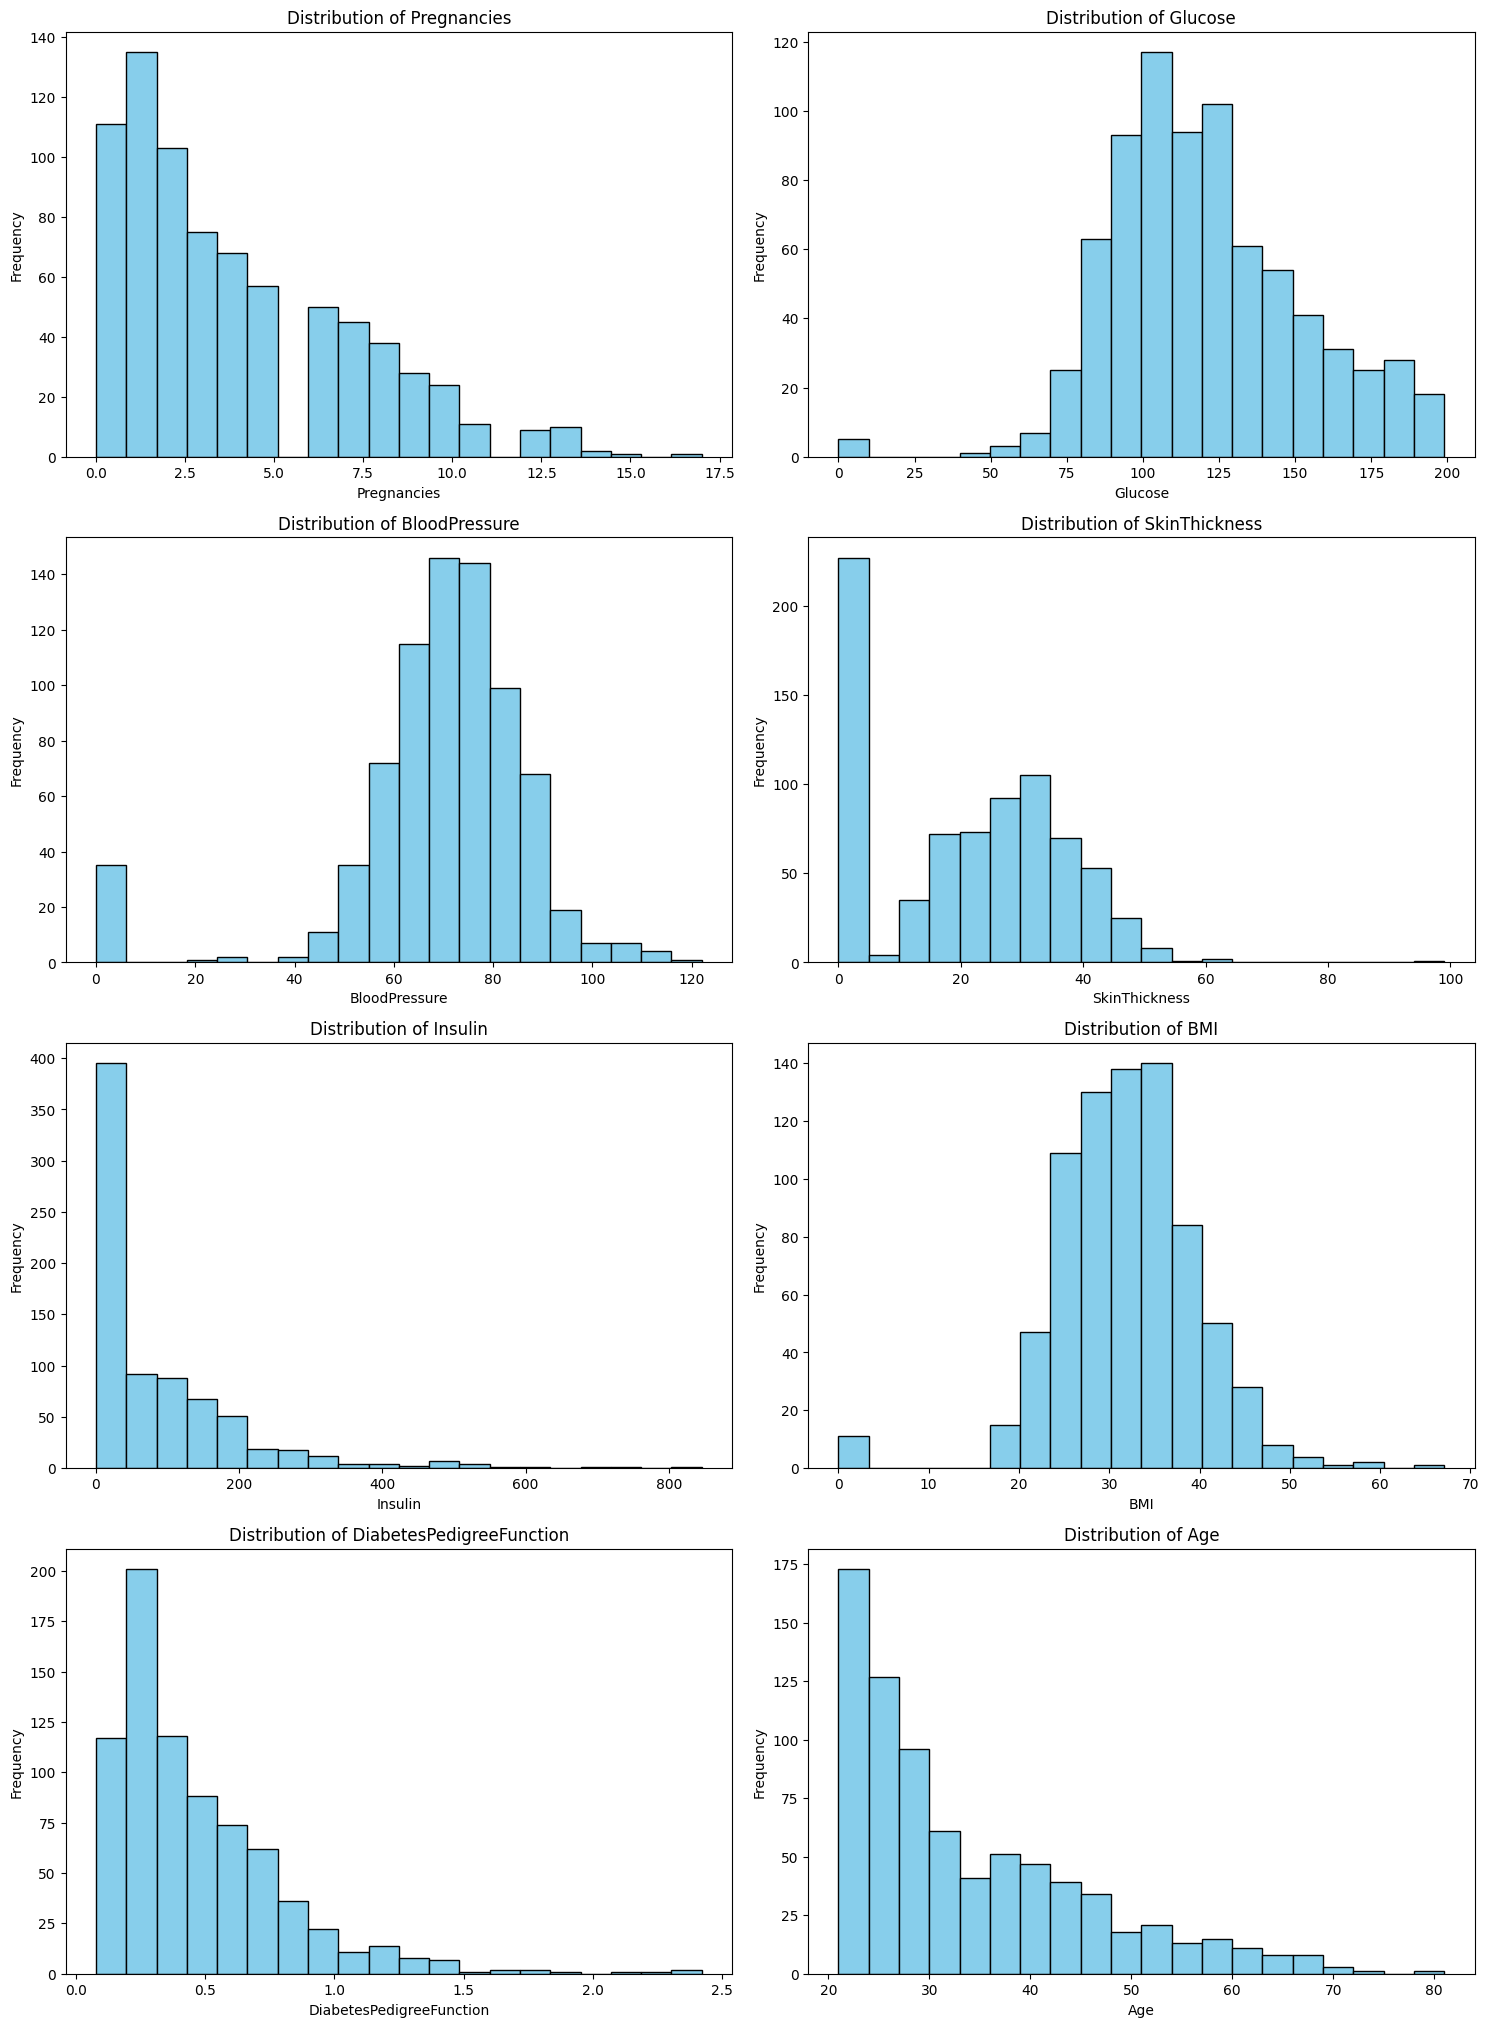

In [3]:
dataset = PimaDataset('../data/diabetes.csv') 

data_features = dataset.data.columns[:-1]
plt.figure(figsize=(15, 25))

for i, feature in enumerate(data_features, 1):
    plt.subplot(5, 2, i)
    plt.hist(dataset.data[feature], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


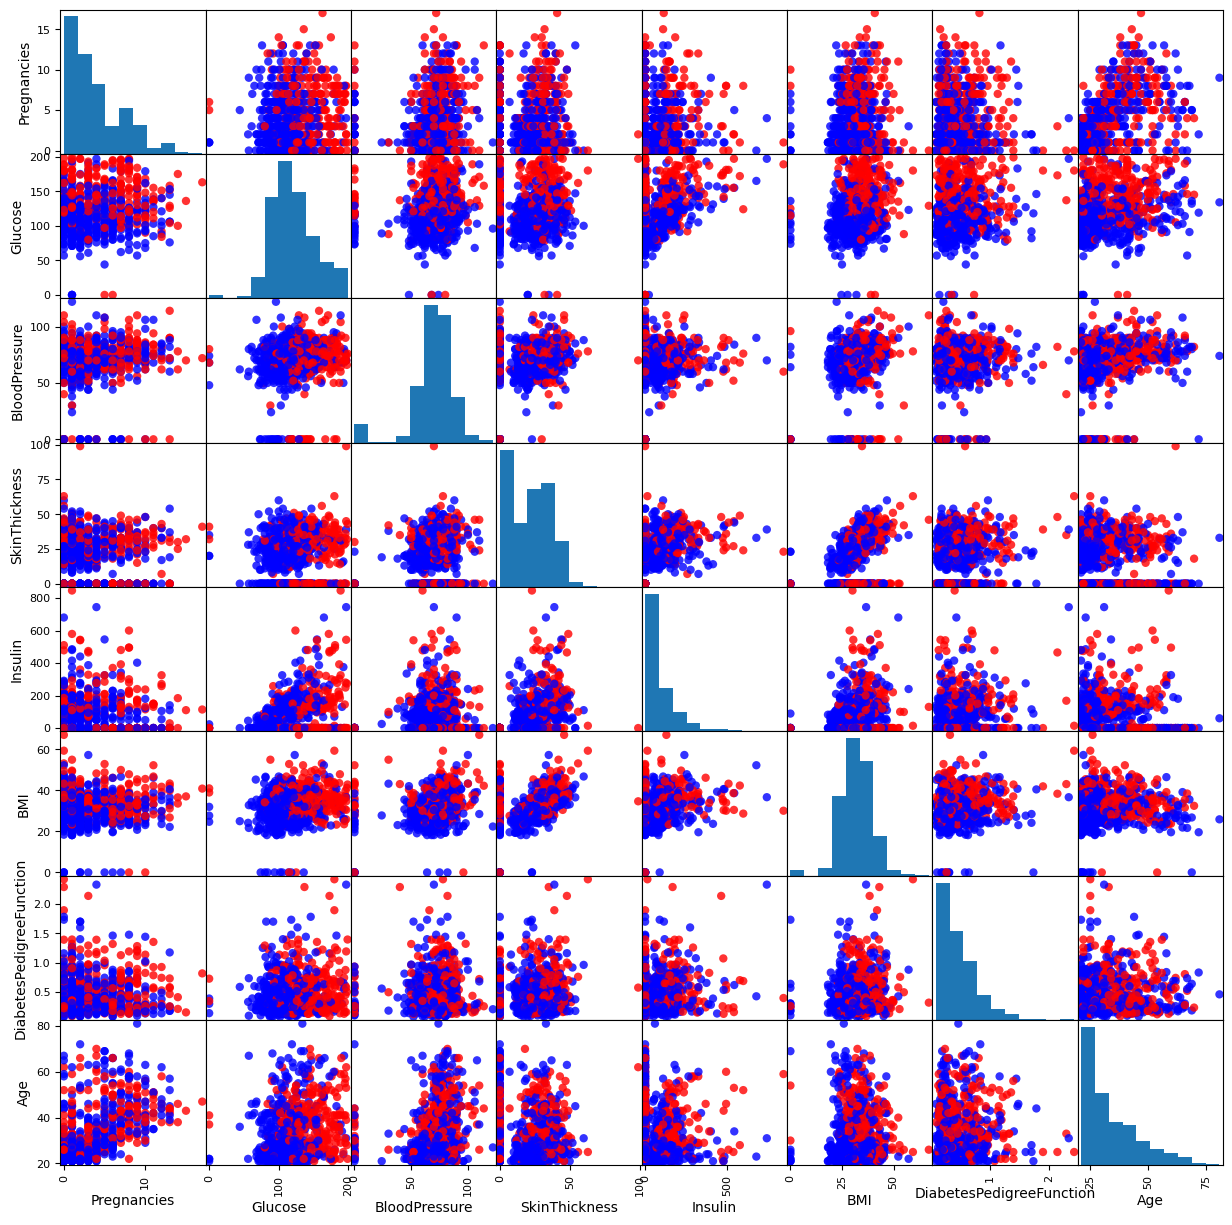

In [58]:
from pandas.plotting import scatter_matrix

colors = {0: "blue", 1: "red"}
outcome_colors = dataset.data['Outcome'].map(colors)

scatter_matrix(dataset.data[data_features], figsize=(15, 15), marker='o', c=outcome_colors, alpha=0.8)
plt.show()

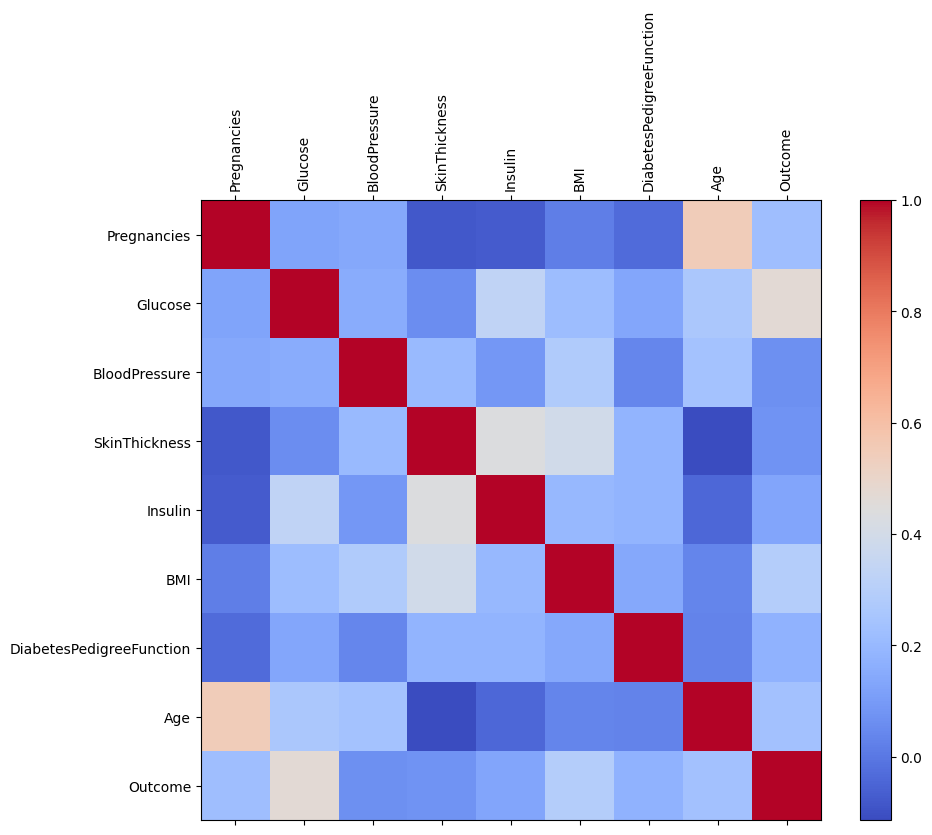

In [5]:
correlation_matrix = dataset.data.corr()

# correlation_matrix = correlation_matrix.iloc

# Plot heatmap
plt.figure(figsize=(10, 8))
plt.matshow(correlation_matrix, cmap="coolwarm", fignum=1)
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

In [34]:
print(dataset.data.describe()) 

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

,Chi2 Stat,p-value,dof,critical_value
Glucose,172.048649,3.799717e-36,4.0,9.487729
BMI,77.342564,6.364317e-16,4.0,9.487729
Age,64.018859,4.141136e-13,4.0,9.487729
Pregnancies,50.030110,3.558971e-10,4.0,9.487729
DiabetesPedigreeFunction,24.635489,5.955279e-05,4.0,9.487729
Insulin,21.710568,2.288348e-04,4.0,9.487729
BloodPressure,17.128258,1.825120e-03,4.0,9.487729
SkinThickness,9.924027,4.172707e-02,4.0,9.487729


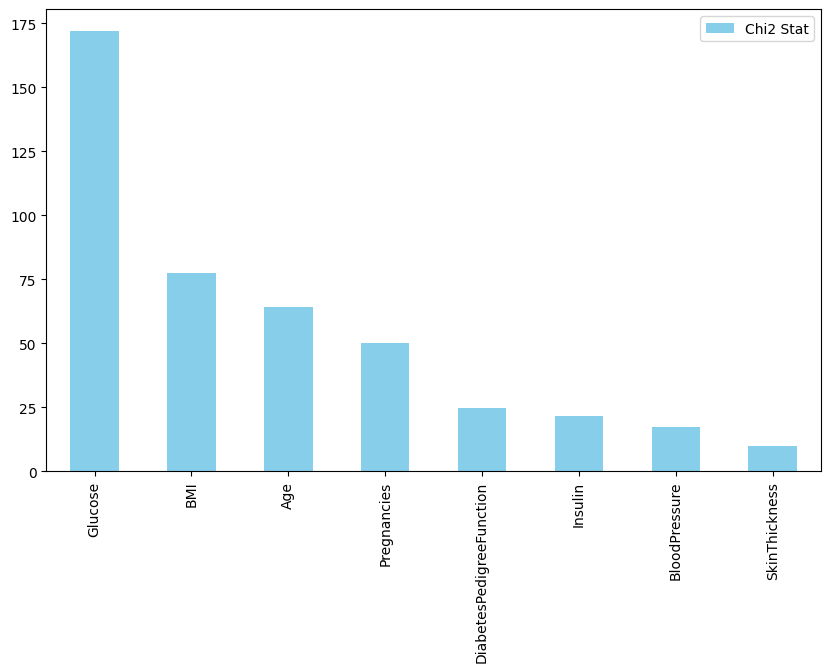

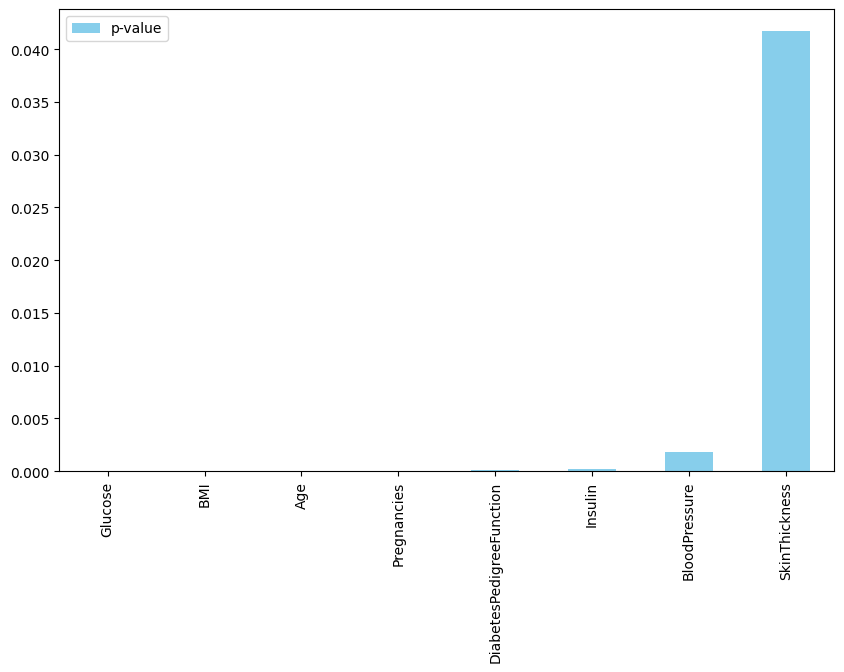

In [47]:
from scipy.stats import chi2_contingency, chi2
from sklearn.preprocessing import KBinsDiscretizer

dataset = PimaDataset('../data/diabetes.csv')

data = dataset.data
X = data.drop(columns=['Outcome'])
y = data['Outcome']
alpha = 0.05

binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
X_binned = pd.DataFrame(binner.fit_transform(X), columns=X.columns)

chi2_results = {}
for feature in X_binned.columns:
    contingency_table = pd.crosstab(X_binned[feature], y)

    # plt.table(cellText=contingency_table.values, rowLabels=contingency_table.index, colLabels=contingency_table.columns, loc='center', cellLoc='center')
    # plt.axis('off')
    # plt.show()

    chi2_stat, p, dof, expected = chi2_contingency(contingency_table)
    critical_value = chi2.ppf(1 - alpha, dof)
    chi2_results[feature] = {"Chi2 Stat": chi2_stat, "p-value": p, "dof": dof, "critical_value": critical_value}

chi2_df = pd.DataFrame(chi2_results).T
chi2_df_sorted = chi2_df.sort_values(by="Chi2 Stat", ascending=False)

chi2_df_sorted.plot(kind='bar', y='Chi2 Stat', color='skyblue', figsize=(10, 6))
chi2_df_sorted.plot(kind='bar', y='p-value', color='skyblue', figsize=(10, 6))
chi2_df_sorted


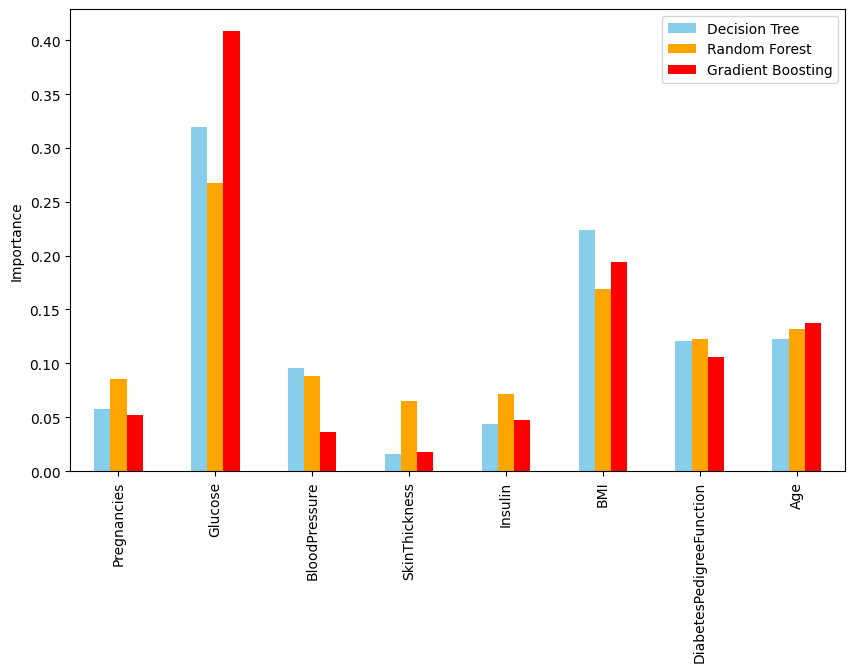

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)

dt.fit(X, y)
rf.fit(X, y)
gb.fit(X, y)

dt_importances = dt.feature_importances_
rf_importances = rf.feature_importances_
gb_importances = gb.feature_importances_

importances_df = pd.DataFrame({'Decision Tree': dt_importances, 'Random Forest': rf_importances, 'Gradient Boosting': gb_importances})

importances_df.set_index(X.columns).plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange', 'red'])
plt.ylabel('Importance')
plt.show()
